# Template Pipeline
Normalisation&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**X -> Gaussian**  
Imputation 1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Outlier Detection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Z Score**  
Imputation 2&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Feature Selection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Implicit to model**  
Model&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Lasso Regression**


## Imports

In [ ]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ML
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, BayesianRidge, LassoLarsCV
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

# Custom
import sys,os
sys.path.append('/home/jovyan/work/AML/Task_1/Solution') # I would like a cleaner solution but works for now
import Components.Imputation as Imputation
import Components.Outlier_Detection_1D as Outlier_Detection_1D
import Components.Outlier_Detection_ND as Outlier_Detection_ND
import Components.Feature_Selection as Feature_Selection
import Components.Normalisation as Normalisation
import Components.data_fetching as data_fetching
import Components.data_observations as data_observations

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(Imputation)
importlib.reload(Outlier_Detection_1D)
importlib.reload(Outlier_Detection_ND)
importlib.reload(Feature_Selection)
importlib.reload(Normalisation)
importlib.reload(data_fetching)
importlib.reload(data_observations)

<module 'Components.data_observations' from '/home/jovyan/work/AML/Task_1/Solution/Components/data_observations.py'>

## Data Cleaning

In [ ]:

X, y = data_fetching.get_train_data()

missing_vals_mask = Imputation.missing_values_mask(X)
X = Imputation.median(X)
X = Normalisation.gaussian(X)
mask = missing_vals_mask
#X,y,mask = Outlier_Detection_ND.mahalanobis_distance(X,y,alpha=3, mask=missing_vals_mask)
#X,y,mask = Outlier_Detection_ND.dbscan(X,y,mask=missing_vals_mask)
#X,y,mask = Outlier_Detection_ND.isolation_forest(X,y,mask=missing_vals_mask)
X = Outlier_Detection_1D.z_score(X, verbose=True)
X,y,mask = Outlier_Detection_ND.magic_indices(X,y,n_outliers=100, mask=missing_vals_mask)
X = X.mask(mask) # Re-impute the ones we imputed before
X = Imputation.iterative_regression(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

/home/jovyan/work/AML/Task_1/Solution/Components/Outlier_Detection_ND.py:47: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask == '':
# Outliers:  1167
/opt/venv/lib/python3.7/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


## Model Training

### Simple

In [ ]:
print(X.shape)

(1162, 832)


In [ ]:
for a in np.linspace(0.05, 0.5,20):
    print('\nAlpha: ', a)
    lasso = Lasso(normalize=False, max_iter=1000, alpha=a)
    
    scores = cross_val_score(lasso, X, y, cv=3, scoring='r2')
    print(scores)
    print(scores.mean())
    #print('Train Score:')
    #y_pred_train = lasso.predict(x_train)
    #train_score = r2_score(y_train, y_pred_train)
    #print(train_score)

    #print('Test Score')
    #y_pred_test = lasso.predict(x_test)
    #test_score = r2_score(y_test, y_pred_test)
    #print(test_score)


Alpha:  0.05
[0.55251884 0.59241491 0.62827184]
0.5910685292987893

Alpha:  0.0736842105263158
[0.60851094 0.62955018 0.69091026]
0.6429904633292759

Alpha:  0.09736842105263158
[0.64114671 0.64660745 0.71481442]
0.6675228588627631

Alpha:  0.12105263157894737
[0.66240072 0.65199812 0.72790447]
0.6807677705738747

Alpha:  0.14473684210526316
[0.67479404 0.65136974 0.73387516]
0.6866796478172263

Alpha:  0.16842105263157897
[0.68208968 0.64838488 0.73762726]
0.6893672755384102

Alpha:  0.19210526315789472
[0.68799449 0.64307503 0.73864844]
0.6899059882194322

Alpha:  0.21578947368421053
[0.6918772  0.64038647 0.73779648]
0.6900200519399191

Alpha:  0.23947368421052634
[0.69404641 0.63761221 0.73714541]
0.6896013440292235

Alpha:  0.2631578947368421
[0.693766   0.63442355 0.73643502]
0.6882081890491581

Alpha:  0.2868421052631579
[0.69185213 0.63145666 0.73430521]
0.6858713355152282

Alpha:  0.3105263157894737
[0.6883107  0.62899082 0.73172828]
0.6830099349415552

Alpha:  0.334210526315

### lots of hyperparam tuning

In [ ]:
# control: take all data:
all_k_out_scores = list()
all_k_out_means = list()

for k_out in range(1,250, 10):
    print('leaving out:')
    print(k_out)
    X, y = data_fetching.get_train_data()

    missing_vals_mask = Imputation.missing_values_mask(X)
    X = Imputation.median(X)
    X = Normalisation.gaussian(X)
    mask = missing_vals_mask
    #X,y,mask = Outlier_Detection_ND.mahalanobis_distance(X,y,alpha=3, mask=missing_vals_mask)
    #X,y,mask = Outlier_Detection_ND.dbscan(X,y,mask=missing_vals_mask)
    #X,y,mask = Outlier_Detection_ND.isolation_forest(X,y,mask=missing_vals_mask)
    X,y,mask = Outlier_Detection_ND.magic_indices(X,y,n_outliers=k_out, mask=missing_vals_mask, verbose=False)
    X = Outlier_Detection_1D.z_score(X, verbose=False)
    X = X.mask(mask) # Re-impute the ones we imputed before
    X = Imputation.mean(X)

    #x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
    lasso = Lasso(normalize=False, max_iter=1000, alpha=0.35)
    scores = cross_val_score(lasso, X, y, cv=3, scoring='r2')
    mean = scores.mean()
    all_k_out_means.append(mean)
    all_k_out_scores.append([scores])
    print(scores)
    print(scores.mean())

In [ ]:
print(max)
arr = np.asarray(all_scores_mean).argsort()[-250:][::-1]
magic_index_list = list(arr)
print(list(arr))
for i in arr:
    print('mean')
    print(all_scores_mean[i])
    print('scores')
    print(all_scores[i*3:i*3 +3])


In [ ]:
# leave one out outlier detection
all_scores_mean = list()
all_scores = list()


lasso = Lasso(normalize=False, max_iter=1000, alpha=0.35)
for i in range(X.shape[1]):
    
    X_loo = X.drop(columns=i)
    
    
    scores = cross_val_score(lasso, X_loo, y, cv=3, scoring='r2')
    #print(scores)
    mean = scores.mean()
    #print(mean)
    all_scores_mean.append(mean)
    #print(all_scores_mean)
    all_scores += list(scores)
    if i % 10 == 0:
        print(i)
        print(scores)
        print(mean)

max = np.max(np.asarray(all_scores_mean))
print('max:')
print(max)
print(np.where(np.asarray(all_scores_mean) == max))



0
[0.4794927  0.45863682 0.51259542]
0.48357497671381494
10
[0.47948005 0.45863726 0.51259694]
0.4835714183395199
20
[0.47948104 0.45863681 0.51255828]
0.48355871258553756


40
[0.47948101 0.45863682 0.51259542]
0.4835710796681589
50
[0.47948103 0.45863682 0.51259541]
0.48357108572548685
60
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
70
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
80
[0.47948104 0.45863575 0.51259542]
0.483570735512777
90
[0.47948103 0.45863682 0.51259542]
0.48357108878740274
100
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
110
[0.47948103 0.45863682 0.51259541]
0.48357108775379415
120
[0.47942757 0.45849143 0.51259542]
0.4835048052355215
130
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
140
[0.47948102 0.45863692 0.51259541]
0.4835711167227874
150
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
160
[0.47948103 0.45863682 0.51256814]
0.4835619987011624
170
[0.48046745 0.45863575 0.51188422]
0.48366247130751816
180
[0.47948081 0.45863724 0.51259542]
0.4835711545416152
190
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
200
[0.47948103 0.45863674 0.51259542]
0.4835710650222776
210
[0.4794

300
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
310
[0.47943246 0.45863682 0.51259542]
0.4835548979669187
320
[0.47948103 0.45863682 0.51259542]
0.483571088182092
330
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
340
[0.47948103 0.45863682 0.51259542]
0.483571087479471
350
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
360
[0.47948103 0.45863704 0.51357846]
0.4838988429377889
370
[0.47948103 0.45863682 0.51259542]
0.48357108897031625


380
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
390
[0.47946554 0.45863682 0.51224906]
0.4834504721632195
400
[0.47948103 0.45876758 0.51259542]
0.4836146776061752
410
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
420
[0.47951236 0.45863682 0.51259542]
0.4835815296114814
430
[0.47948103 0.45863682 0.51259542]
0.48357108847263075
440
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
450
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
460
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
470
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
480
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
490
[0.47948103 0.45863682 0.51259542]
0.4835710898206044
500
[0.47948103 0.45870886 0.51259542]
0.48359510233492015
510
[0.47948099 0.45863682 0.51259565]
0.48357115477904494
520
[0.47948103 0.45910286 0.51259542]
0.4837264373232914
530
[0.47948103 0.45863682 0.51259542]
0.48357108854578623
540
[0.4795287  0.45863679 0.51377474]
0.4839800744759044
550

KeyboardInterrupt: 

In [ ]:
lasso = LassoCV(cv=5, random_state=0).fit(x_train, y_train)

print('Train Score:')
y_pred_train = lasso.predict(x_train)
train_score = r2_score(y_train, y_pred_train)
print(train_score)

print('Test Score')
y_pred_test = lasso.predict(x_test)
test_score = r2_score(y_test, y_pred_test)
print(test_score)

/opt/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.867181928630771, tolerance: 6.576660199714695
  positive)
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.685121170556386, tolerance: 6.576660199714695
  positive)
/opt/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.573217476990749, tolerance: 

In [ ]:
plt.hist(y_train.iloc[:,0].to_numpy(), bins='auto')
plt.title('Actual')
plt.show()

plt.hist(y_pred_train, bins='auto')
plt.title('Prediction')
plt.show()

In [ ]:
plt.hist(y_test.iloc[:,0].to_numpy(), bins='auto')
plt.title('Actual')
plt.show()

plt.hist(y_pred_test, bins='auto')
plt.title('Prediction')
plt.show()

## Final Prediction

/opt/venv/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
0.7739529313347979
           y
0  67.925961
1  77.779476
2  64.672013
3  67.625026
4  75.082395


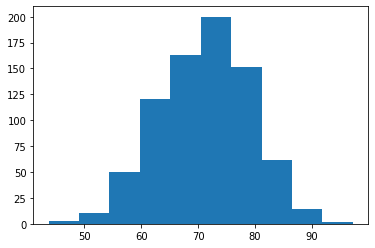

In [ ]:
#lasso_final = Lasso(normalize=False, max_iter=1000, alpha=0.2).fit(X, y)
lasso_final = LassoLarsCV(cv=5).fit(X, y)
# get train score
print(lasso_final.score(X, y))

x_test = data_fetching.get_test_data()

x_test = Imputation.mean(x_test)
x_test = Normalisation.gaussian(x_test)

# Note: They said no outliers were introduced in x_test so no need to perform outlier detection
y_pred = lasso_final.predict(x_test)
plt.hist(y_pred)

y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
print(y_pred_pd.head())
y_pred_pd.to_csv('../../Predictions/loocv_brute_force_100_regrimp_lars.csv', index_label='id')